Loading dataset...
Dataset shape: (40098, 20)
  who_region iso3 country_name          city    year  \
0      4_Eur  ESP        Spain  A Coruna/ESP  2013.0   
1      4_Eur  ESP        Spain  A Coruna/ESP  2014.0   
2      4_Eur  ESP        Spain  A Coruna/ESP  2015.0   
3      4_Eur  ESP        Spain  A Coruna/ESP  2016.0   
4      4_Eur  ESP        Spain  A Coruna/ESP  2017.0   

                                             version  pm10_concentration  \
0  V4.0 (2018), V4.0 (2018), V4.0 (2018), V4.0 (2...              23.238   
1           V6.0  (2023), V6.0  (2023), V6.0  (2023)              27.476   
2  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...              25.515   
3  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...              23.057   
4  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...              26.849   

   pm25_concentration  no2_concentration  pm10_tempcov  pm25_tempcov  \
0              11.491             28.841          87.0          46.0   
1              1

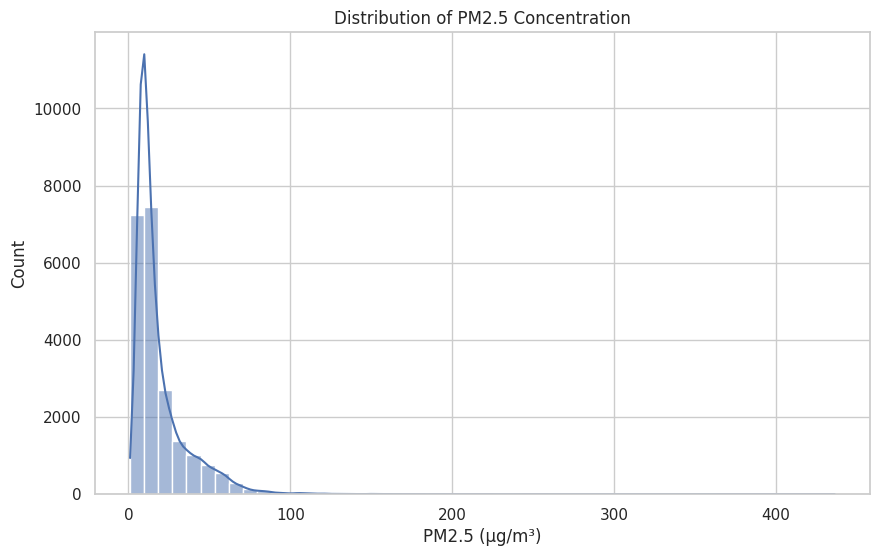

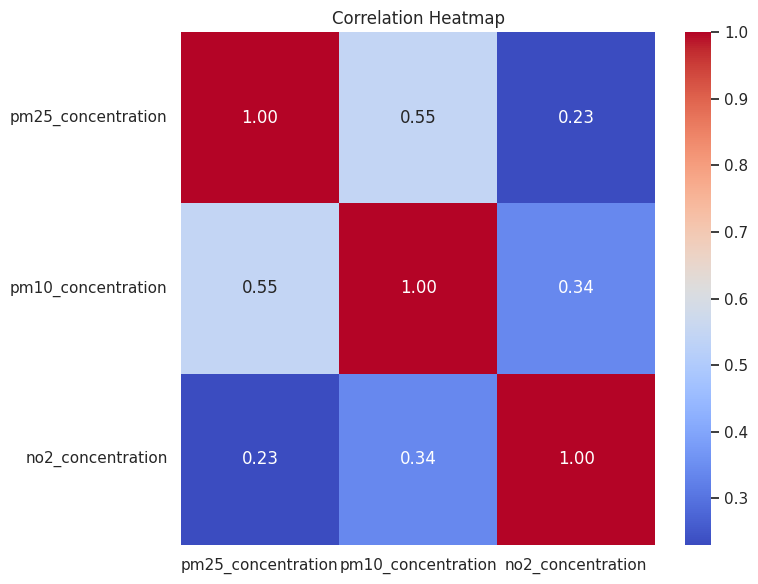


Explained Variance Ratios: [0.6697113 0.3302887]


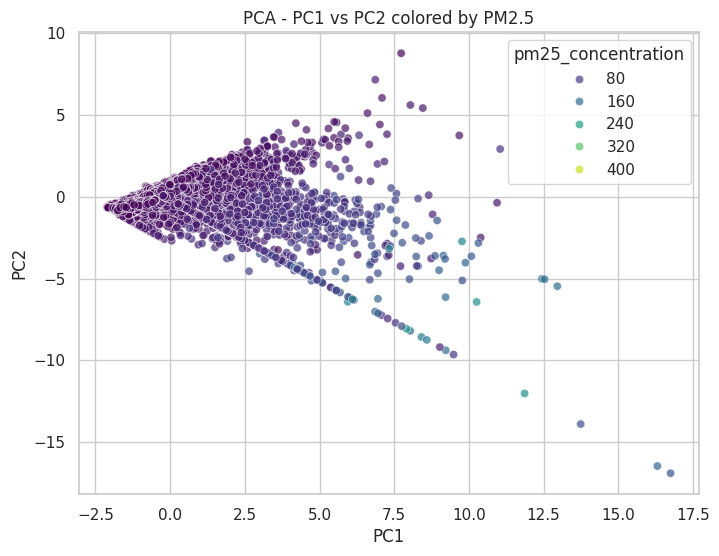


Linear Regression Performance:
R²: 0.303, RMSE: 15.544, MAE: 9.786


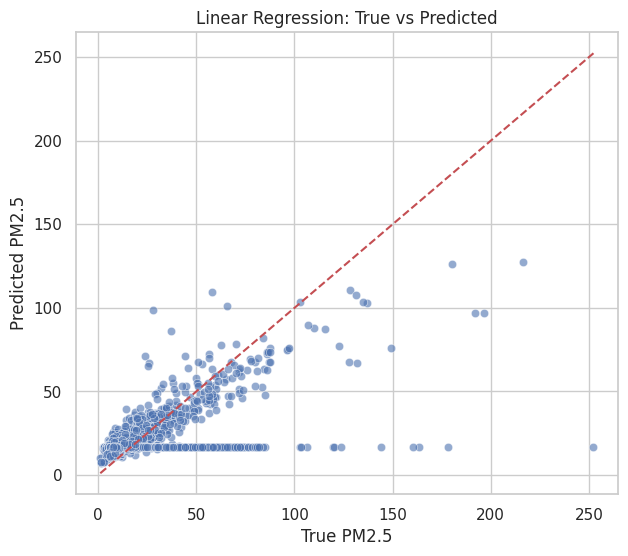


Classification Report (High vs Low PM2.5):
              precision    recall  f1-score   support

           0       0.65      0.86      0.74      2173
           1       0.79      0.54      0.64      2173

    accuracy                           0.70      4346
   macro avg       0.72      0.70      0.69      4346
weighted avg       0.72      0.70      0.69      4346



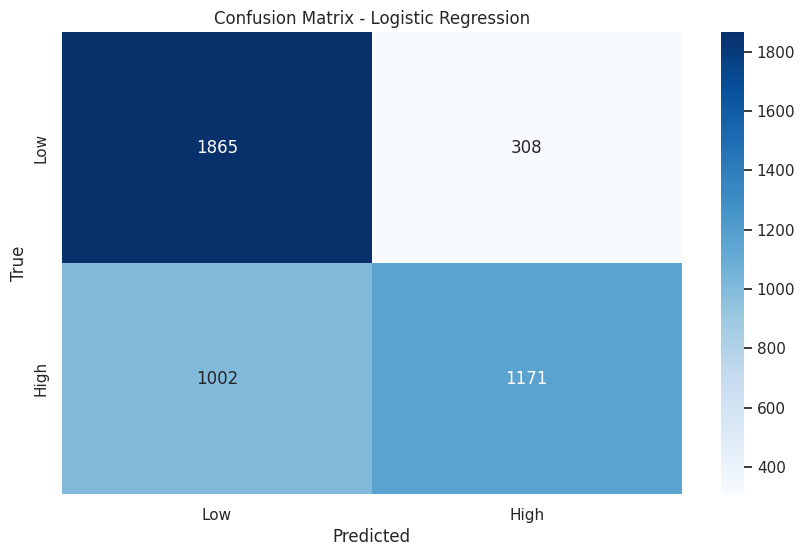

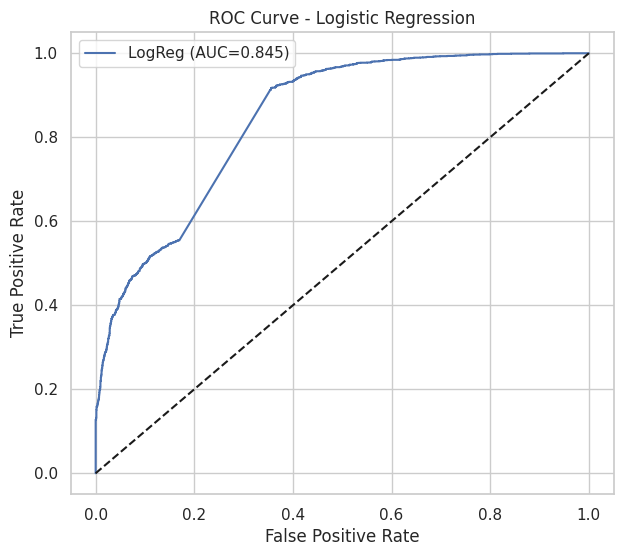


Sample Regression Predictions (10 random rows):
   True_PM25  Pred_PM25
0     17.427  28.628062
1     42.500  17.042145
2      6.650  17.042145
3      9.247  14.552387
4     42.956  17.042145
5     10.898  15.655585
6     12.753  15.147964
7      8.400  17.042145
8     42.346  28.783177
9      9.957  18.621744

Sample Classification Predictions (10 random rows):
  True_Class Pred_Class  Prob_High
0        Low        Low   0.048161
1       High        Low   0.458163
2       High       High   0.911606
3        Low        Low   0.051014
4        Low        Low   0.401517
5        Low        Low   0.288866
6       High       High   0.999999
7        Low        Low   0.458163
8        Low        Low   0.111799
9       High       High   0.958341

--- Summary ---
Linear Regression: R²=0.303, RMSE=15.544, MAE=9.786
Logistic Regression ROC AUC: 0.845
All plots, metrics, and sample outputs saved/generated.


In [20]:
# WHO Air Quality - PCA + Regression + Classification

# ---- 1. Setup ----
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    classification_report, confusion_matrix, roc_curve, auc
)

# Config
DATA_PATH = "air_quality.xlsx"   # update with your dataset path
TARGET = "pm25_concentration"    # target column
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_STATE = 42
TEST_SIZE = 0.2

# ---- 2. Load Data ----
print("Loading dataset...")
if DATA_PATH.lower().endswith((".xls", ".xlsx")):
    xls = pd.ExcelFile(DATA_PATH)
    # pick largest sheet
    sheet = max(xls.sheet_names, key=lambda s: pd.read_excel(xls, s).shape[0])
    df = pd.read_excel(xls, sheet_name=sheet)
else:
    df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
print(df.head())

# ---- 3. Select Features ----
candidate_numeric = [
    "pm25_concentration", "pm10_concentration", "no2_concentration",
    "o3_concentration", "pm25_coverage", "pm10_coverage",
    "no2_coverage", "o3_coverage"
]
meta_cols = [c for c in ["who_region", "country", "city", "year"] if c in df.columns]
num_cols = [c for c in candidate_numeric if c in df.columns]

data = df[meta_cols + num_cols].copy()

# Drop rows without target
data = data.dropna(subset=[TARGET])
print("After dropping NaNs in target:", data.shape)

# Fill missing numeric with median
for c in num_cols:
    data[c] = pd.to_numeric(data[c], errors="coerce")
    data[c] = data[c].fillna(data[c].median())

# ---- 4. Exploratory Data Analysis ----
sns.set(style="whitegrid", rc={"figure.figsize": (10,6)})

# Distribution of PM2.5
plt.figure()
sns.histplot(data[TARGET], bins=50, kde=True)
plt.title("Distribution of PM2.5 Concentration")
plt.xlabel("PM2.5 (µg/m³)")
plt.savefig(os.path.join(OUT_DIR, "eda_distribution_pm25.png"))
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "eda_correlation.png"))
plt.show()

# ---- 5. PCA ----
features = [c for c in num_cols if c != TARGET]
X_pca = data[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

n_features = X_scaled.shape[1]
pca = PCA(n_components=min(3, n_features), random_state=RANDOM_STATE)
X_pca_res = pca.fit_transform(X_scaled)

print("\nExplained Variance Ratios:", pca.explained_variance_ratio_)

pca_df = pd.DataFrame(X_pca_res, columns=[f"PC{i+1}" for i in range(X_pca_res.shape[1])])
pca_df[TARGET] = data[TARGET].values

plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", hue=TARGET, data=pca_df, palette="viridis", alpha=0.7)
plt.title("PCA - PC1 vs PC2 colored by PM2.5")
plt.savefig(os.path.join(OUT_DIR, "pca_scatter.png"))
plt.show()

# ---- 6. Regression (Linear Regression) ----
X = data[features].values
y = data[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nLinear Regression Performance:")
print(f"R²: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

# True vs Pred
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Linear Regression: True vs Predicted")
plt.savefig(os.path.join(OUT_DIR, "regression_true_vs_pred.png"))
plt.show()

# ---- 7. Classification (Logistic Regression) ----
median_pm25 = np.median(y)
data["pm25_high"] = (data[TARGET] > median_pm25).astype(int)

Xc = data[features].values
yc = data["pm25_high"].values

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=yc
)

scaler_c = StandardScaler()
Xc_train_scaled = scaler_c.fit_transform(Xc_train)
Xc_test_scaled = scaler_c.transform(Xc_test)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(Xc_train_scaled, yc_train)
yc_pred = logreg.predict(Xc_test_scaled)
yc_prob = logreg.predict_proba(Xc_test_scaled)[:,1]

print("\nClassification Report (High vs Low PM2.5):")
print(classification_report(yc_test, yc_pred))

cm = confusion_matrix(yc_test, yc_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low","High"], yticklabels=["Low","High"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(OUT_DIR, "classification_confusion_matrix.png"))
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(yc_test, yc_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"LogReg (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "classification_roc_curve.png"))
plt.show()

# ---- 8. Sample Predictions ----
# Regression: show 10 random samples
sample_idx = np.random.choice(len(X_test_scaled), 10, replace=False)
sample_reg = pd.DataFrame({
    "True_PM25": y_test[sample_idx],
    "Pred_PM25": y_pred[sample_idx]
})
print("\nSample Regression Predictions (10 random rows):")
print(sample_reg)

# Classification: show 10 random samples
sample_idx_c = np.random.choice(len(Xc_test_scaled), 10, replace=False)
sample_clf = pd.DataFrame({
    "True_Class": yc_test[sample_idx_c],
    "Pred_Class": yc_pred[sample_idx_c],
    "Prob_High": yc_prob[sample_idx_c]
})
sample_clf["True_Class"] = sample_clf["True_Class"].map({0:"Low", 1:"High"})
sample_clf["Pred_Class"] = sample_clf["Pred_Class"].map({0:"Low", 1:"High"})
print("\nSample Classification Predictions (10 random rows):")
print(sample_clf)

# ---- 9. Conclusion ----
print("\n--- Summary ---")
print(f"Linear Regression: R²={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")
print(f"Logistic Regression ROC AUC: {roc_auc:.3f}")
print("All plots, metrics, and sample outputs saved/generated.")


🔹 Loading dataset...
✅ Dataset loaded. Shape: (40098, 20)
  who_region iso3 country_name          city    year  \
0      4_Eur  ESP        Spain  A Coruna/ESP  2013.0   
1      4_Eur  ESP        Spain  A Coruna/ESP  2014.0   
2      4_Eur  ESP        Spain  A Coruna/ESP  2015.0   
3      4_Eur  ESP        Spain  A Coruna/ESP  2016.0   
4      4_Eur  ESP        Spain  A Coruna/ESP  2017.0   

                                             version  pm10_concentration  \
0  V4.0 (2018), V4.0 (2018), V4.0 (2018), V4.0 (2...              23.238   
1           V6.0  (2023), V6.0  (2023), V6.0  (2023)              27.476   
2  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...              25.515   
3  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...              23.057   
4  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...              26.849   

   pm25_concentration  no2_concentration  pm10_tempcov  pm25_tempcov  \
0              11.491             28.841          87.0          46.0   
1   

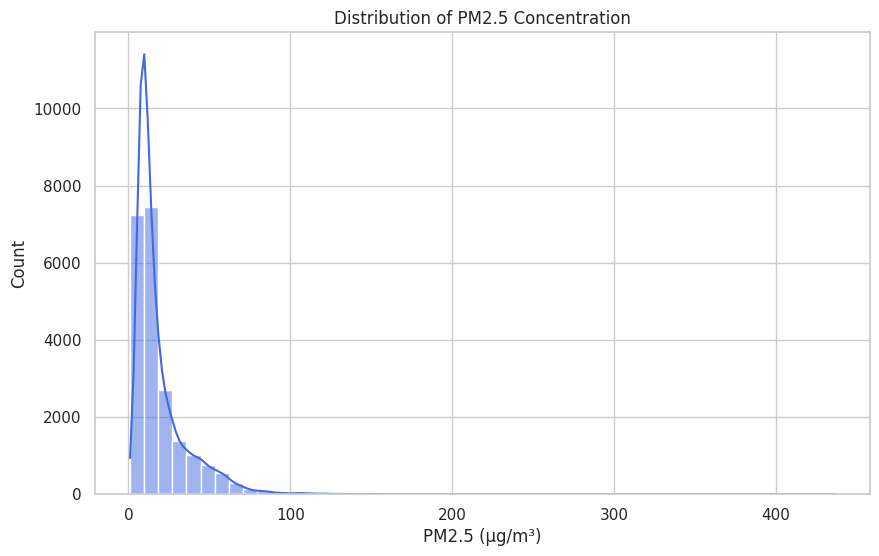

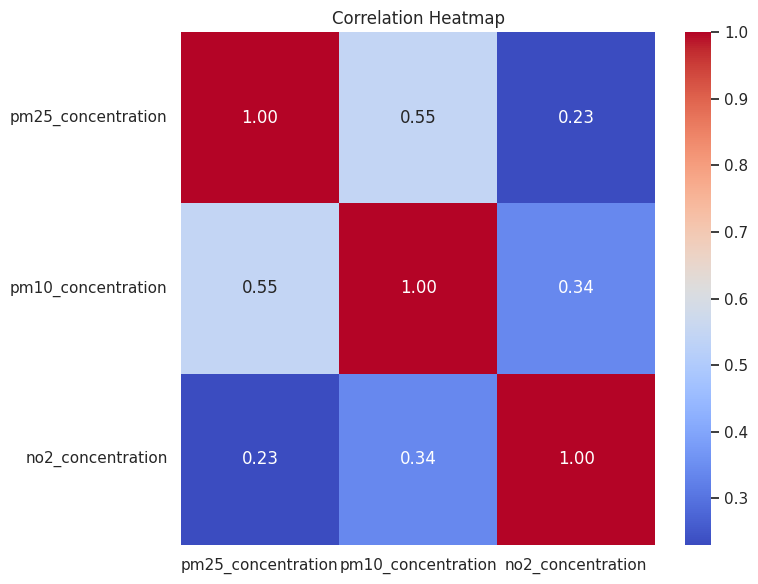

🔹 PCA Explained Variance Ratios: [0.6697113 0.3302887] 



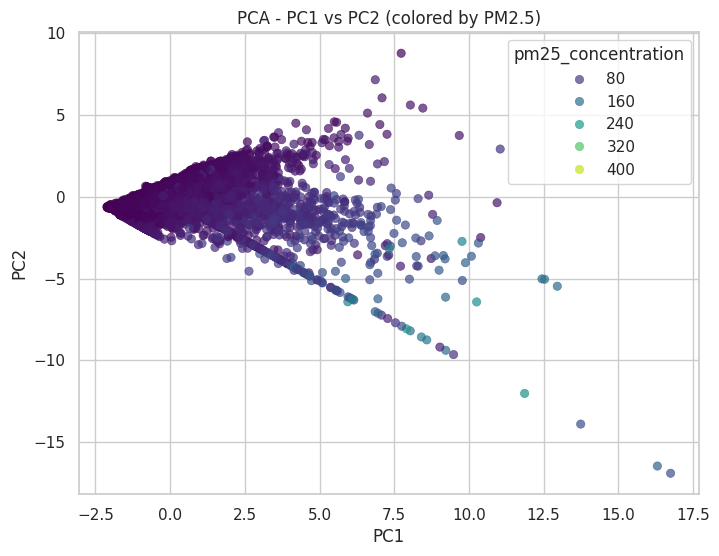

📊 Linear Regression Performance:
  R²   = 0.303
  RMSE = 15.544
  MAE  = 9.786



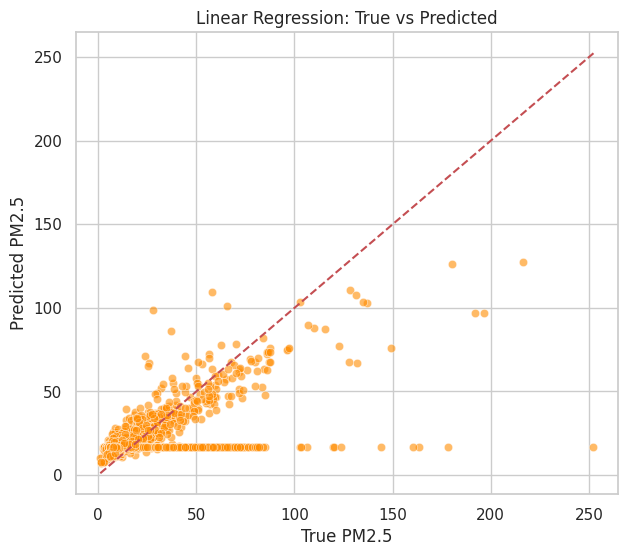

📊 Classification Report (High vs Low PM2.5):
              precision    recall  f1-score   support

           0       0.65      0.86      0.74      2173
           1       0.79      0.54      0.64      2173

    accuracy                           0.70      4346
   macro avg       0.72      0.70      0.69      4346
weighted avg       0.72      0.70      0.69      4346
 



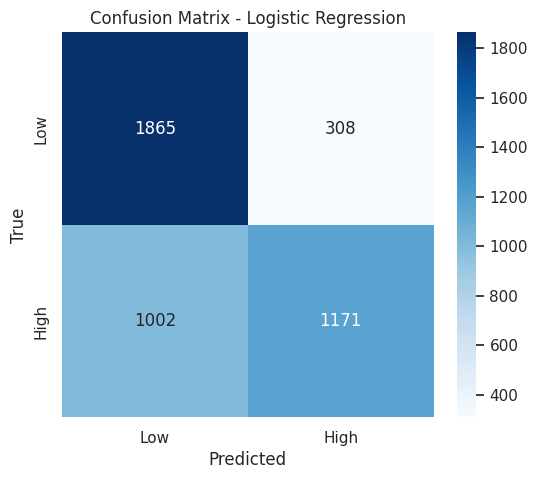

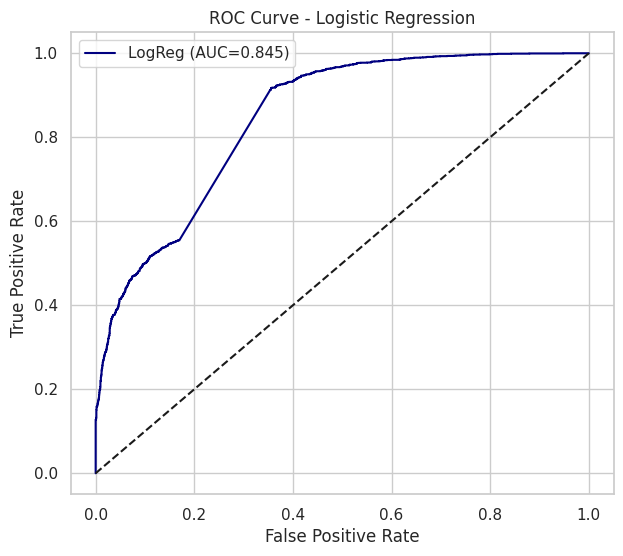

🔹 Sample Regression Predictions (10 rows):
 True_PM25  Pred_PM25
     7.600  17.042145
     8.000  17.042145
    10.964  14.963783
    52.479  17.042145
    10.352  16.431872
    24.128  25.288370
    27.912  16.822210
     8.200  13.699931
    57.910  48.668702
     9.982  13.310039 

🔹 Sample Classification Predictions (10 rows):
True_Class Pred_Class  Prob_High
      High        Low   0.458163
       Low        Low   0.140454
       Low        Low   0.458163
      High        Low   0.458163
      High        Low   0.171585
      High        Low   0.326681
      High        Low   0.458163
       Low        Low   0.040101
       Low       High   0.849350
       Low        Low   0.082828 

📊 Final Metrics Summary:

              Model       R²      RMSE      MAE  ROC AUC
  Linear Regression 0.303357 15.544146 9.785879      NaN
Logistic Regression      NaN       NaN      NaN 0.844786 

✅ Analysis Complete
All plots displayed & saved in: outputs


In [22]:
# ==========================================================
# WHO Air Quality Analysis
# PCA + Regression + Classification Pipeline
# ==========================================================

import os
import warnings
warnings.filterwarnings("ignore")

# Data & Math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML Tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    classification_report, confusion_matrix, roc_curve, auc
)

# ----------------------------------------------------------
# Config
# ----------------------------------------------------------
DATA_PATH   = "air_quality.xlsx"       # dataset path
TARGET      = "pm25_concentration"     # target column
OUT_DIR     = "outputs"
RANDOM_STATE = 42
TEST_SIZE    = 0.2

os.makedirs(OUT_DIR, exist_ok=True)
sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})

# ----------------------------------------------------------
# 1. Load Data
# ----------------------------------------------------------
print("🔹 Loading dataset...")
if DATA_PATH.lower().endswith((".xls", ".xlsx")):
    xls = pd.ExcelFile(DATA_PATH)
    sheet = max(xls.sheet_names, key=lambda s: pd.read_excel(xls, s).shape[0])
    df = pd.read_excel(xls, sheet_name=sheet)
else:
    df = pd.read_csv(DATA_PATH)

print("✅ Dataset loaded. Shape:", df.shape)
print(df.head(), "\n")

# ----------------------------------------------------------
# 2. Feature Selection & Cleaning
# ----------------------------------------------------------
candidate_numeric = [
    "pm25_concentration", "pm10_concentration", "no2_concentration",
    "o3_concentration", "pm25_coverage", "pm10_coverage",
    "no2_coverage", "o3_coverage"
]
meta_cols = [c for c in ["who_region", "country", "city", "year"] if c in df.columns]
num_cols  = [c for c in candidate_numeric if c in df.columns]

data = df[meta_cols + num_cols].copy()

# Drop missing targets
data = data.dropna(subset=[TARGET])
print("✅ After dropping NaNs in target:", data.shape)

# Fill numeric NaNs with median
for c in num_cols:
    data[c] = pd.to_numeric(data[c], errors="coerce")
    data[c] = data[c].fillna(data[c].median())

# ----------------------------------------------------------
# 3. Exploratory Data Analysis (EDA)
# ----------------------------------------------------------
plt.figure()
sns.histplot(data[TARGET], bins=50, kde=True, color="royalblue")
plt.title("Distribution of PM2.5 Concentration")
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Count")
plt.savefig(os.path.join(OUT_DIR, "eda_distribution_pm25.png"))
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(data[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "eda_correlation.png"))
plt.show()

# ----------------------------------------------------------
# 4. PCA
# ----------------------------------------------------------
features = [c for c in num_cols if c != TARGET]
X_pca = data[features].values
X_scaled = StandardScaler().fit_transform(X_pca)

n_features = X_scaled.shape[1]
pca = PCA(n_components=min(3, n_features), random_state=RANDOM_STATE)
X_pca_res = pca.fit_transform(X_scaled)

print("🔹 PCA Explained Variance Ratios:", pca.explained_variance_ratio_, "\n")

pca_df = pd.DataFrame(X_pca_res, columns=[f"PC{i+1}" for i in range(X_pca_res.shape[1])])
pca_df[TARGET] = data[TARGET].values

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue=TARGET, data=pca_df,
                palette="viridis", alpha=0.7, edgecolor=None)
plt.title("PCA - PC1 vs PC2 (colored by PM2.5)")
plt.savefig(os.path.join(OUT_DIR, "pca_scatter.png"))
plt.show()

# ----------------------------------------------------------
# 5. Regression (Linear Regression)
# ----------------------------------------------------------
X = data[features].values
y = data[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# Metrics
r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print("📊 Linear Regression Performance:")
print(f"  R²   = {r2:.3f}")
print(f"  RMSE = {rmse:.3f}")
print(f"  MAE  = {mae:.3f}\n")

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="darkorange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Linear Regression: True vs Predicted")
plt.savefig(os.path.join(OUT_DIR, "regression_true_vs_pred.png"))
plt.show()

# ----------------------------------------------------------
# 6. Classification (Logistic Regression)
# ----------------------------------------------------------
median_pm25 = np.median(y)
data["pm25_high"] = (data[TARGET] > median_pm25).astype(int)

Xc = data[features].values
yc = data["pm25_high"].values

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=yc
)

scaler_c = StandardScaler()
Xc_train_scaled = scaler_c.fit_transform(Xc_train)
Xc_test_scaled  = scaler_c.transform(Xc_test)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(Xc_train_scaled, yc_train)
yc_pred = logreg.predict(Xc_test_scaled)
yc_prob = logreg.predict_proba(Xc_test_scaled)[:, 1]

print("📊 Classification Report (High vs Low PM2.5):")
print(classification_report(yc_test, yc_pred), "\n")

cm = confusion_matrix(yc_test, yc_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(OUT_DIR, "classification_confusion_matrix.png"))
plt.show()

fpr, tpr, _ = roc_curve(yc_test, yc_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"LogReg (AUC={roc_auc:.3f})", color="navy")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "classification_roc_curve.png"))
plt.show()

# ----------------------------------------------------------
# 7. Sample Predictions
# ----------------------------------------------------------
sample_idx = np.random.choice(len(X_test_scaled), 10, replace=False)
sample_reg = pd.DataFrame({
    "True_PM25": y_test[sample_idx],
    "Pred_PM25": y_pred[sample_idx]
})
print("🔹 Sample Regression Predictions (10 rows):")
print(sample_reg.to_string(index=False), "\n")

sample_idx_c = np.random.choice(len(Xc_test_scaled), 10, replace=False)
sample_clf = pd.DataFrame({
    "True_Class": yc_test[sample_idx_c],
    "Pred_Class": yc_pred[sample_idx_c],
    "Prob_High": yc_prob[sample_idx_c]
})
sample_clf["True_Class"] = sample_clf["True_Class"].map({0: "Low", 1: "High"})
sample_clf["Pred_Class"] = sample_clf["Pred_Class"].map({0: "Low", 1: "High"})
print("🔹 Sample Classification Predictions (10 rows):")
print(sample_clf.to_string(index=False), "\n")

# ----------------------------------------------------------
# 8. Metrics Summary Table
# ----------------------------------------------------------
summary_df = pd.DataFrame({
    "Model": ["Linear Regression", "Logistic Regression"],
    "R²":    [r2, None],
    "RMSE":  [rmse, None],
    "MAE":   [mae, None],
    "ROC AUC": [None, roc_auc]
})

print("📊 Final Metrics Summary:\n")
print(summary_df.to_string(index=False), "\n")

# ----------------------------------------------------------
# 9. Conclusion
# ----------------------------------------------------------
print("===================================================")
print("✅ Analysis Complete")
print("All plots displayed & saved in:", OUT_DIR)
print("===================================================")
